## Genetic Algorithm for optimizing city transport routes
 
 ### Description of our scenario
 
 - Gene: a key point of interest of the city
 - Individual (aka “chromosome”): any possible transport route, a sequence of locations we visit
 - Fitness: a function that tells us how good each route is (in our case, how low the length is and how high the diversity of the route is )

In [1]:
pip install pandas

In [2]:
import numpy as np, operator
import pandas as pd 
import matplotlib.pyplot as plt
import networkx as nx
import random

### Representation of a gene (a place of the city)
Let's create a Place class that represents a place of the city (as we saw in the article about the TSP, we will consider a place by using 2 coordinates and we will calculate the distance between two places using the Pythagorean theorem)

In [3]:
class Place:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, place):
        xDis = abs(self.x - place.x)
        yDis = abs(self.y - place.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

Now, let's assign coordinates to the interest points of the city that we are given in the instructions. We are going to use a dictionary to make things easier (each label will have an object Place associated). Thus, our sample data is the following one:

In [4]:
myCity = {}

myCity['R1']  = Place(3,6)
myCity['R2']  = Place(5,2)
myCity['R3']  = Place(2,4)

myCity['B1']  = Place(9,1)
myCity['B2']  = Place(4,7)

myCity['S1']  = Place(1,8)
myCity['S2']  = Place(6,9)

myCity['H1']  = Place(7,3)

myCity['SC1'] = Place(8,5)
myCity['SC2'] = Place(0,0)

### Representation of an Individual Solution 


We need to create our initial population, so we will define a function that will produce random routes. We will check if they connect a residential area or not, the diversity of the route and the cummulated distance using the fitness function.

In [5]:
def createRoute(city):
    route = random.sample(list(city.keys()), int(len(city)*0.4))
    return route

### Initialization

Now we use the function we have already defined to define the function that creates our initial population:

In [6]:
def initialPopulation(popSize, city):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(city))
    return population

### Fitness function

A route will be better if it connects a residential area with other opints of the city and it has a distance lower than 10. If the distance is greater than 10, this will be penalized. Lastly, we will also add positive value to those routes which include different places (diversity). To track the different places visited, we will use a set. The penalization will be total when the totalDistance is greater or equal to 10. For intermediate cases, penalization will be calculated using a quaotient between the totalDistance and maxDistance.

In [7]:
def valueFitness(route, city):
    
    totalDistance = 0
    maxDistance = 10
    trackedAreas = set()
    residentialArea = 0
    
    for i in range(0, len(route)-1):
        
        trackedAreas.add(route[i])
        totalDistance += city[route[i]].distance(city[route[i+1]])
        
        if route[i][0] == 'R':
            residentialArea = 1
 
    lastPlace = route[len(route)-1]
    trackedAreas.add(lastPlace)   
    if lastPlace[0] == 'R':
            residentialArea = 1
        
        
    penalized = max(0, 1 - totalDistance/maxDistance)
    diversity = len(trackedAreas)/len(route)
        
    fitness = residentialArea * penalized + diversity**2
    return fitness

To simulate our “survival of the fittest”, we can use the function valueFitness to rank each individual in the population. Our output will be an ordered list with the route IDs (index in population) and each associated fitness score.

In [8]:
def rankRoutes(population, city):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = valueFitness(population[i], city)
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

### Selection method

We would have to select a subgroup from the population such that this group constitutes the mating pool. For this, we need to define a selection mechanism. Let's see:

In [9]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
        
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Now that we have the IDs of the combinations that will make up our mating pool from the selection function, we can create the mating pool. We’re simply extracting the selected individuals from our population.

In [10]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

### Crossover 
We will implement a simple crossover: pick a crossover point and splice the two strings together to produce an offspring.

In [11]:
def breed(parent1, parent2):
    child = []
    length = len(parent1)
    splitpoint = random.randint(0, length)

    for i in range(0, splitpoint):
        child.append(parent1[i])
        
    for i in range(splitpoint, length):
        child.append(parent2[i])
        
    return child

Next we'll generalize this to create our offspring population

In [12]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

### Mutation

We’ll use swap mutation. This means that, with specified low probability, a place from our route can be changed by another one in the city. We’ll do this for one individual in our mutate function:

In [13]:
mRate = 0.01

In [14]:
def mutate(individual, mutationRate, city):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            
            index = int(random.random() * len(city))
            swapWith = list(city.keys())[index]
            
            individual[swapped] = swapWith
            
    return individual

Next, we can extend the mutate function to run through the new population.

In [15]:
def mutatePopulation(population, mutationRate, city):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate, city)
        mutatedPop.append(mutatedInd)
    return mutatedPop

### Creating a New Generation

Let’s pull these pieces together to create a function that produces a new generation. First, we rank the routes in the current generation using rankRoutes. We then determine our potential parents by running the selection function, which allows us to create the mating pool using the matingPool function. Finally, we then create our new generation using the breedPopulation function and then applying mutation using the mutatePopulation function.

In [16]:
def nextGeneration(currentGen, eliteSize, mutationRate, city):
   
    popRanked = rankRoutes(currentGen, city)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate, city)
    return nextGeneration

### Termination Condition

Finally, we will impose a termination condition. In this way, we can automate the creation of new generations, stopping once we have reached a satisfactory fitness level or when we've already iterated too much. In our case, we won't iterate more than 500 times.

In [17]:
ngenerations = 500

The following function is useful for automating the creation of generations we've discussed.

In [18]:
def geneticAlgorithm(city, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, city)
    print("Initial value: " + str(rankRoutes(pop, city)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate, city)
    
    print("Final value: " + str(rankRoutes(pop, city)[0][1]))
    bestRouteIndex = rankRoutes(pop, city)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

### Running the genetic algorithm

Finally, we can apply this last function in order to apply genetic algorithm to our sample of data and, in this way, find a good route that connects various locations in the city. Our sample data is the following:

In [19]:
myCity = {}

myCity['R1']  = Place(3,6)
myCity['R2']  = Place(5,2)
myCity['R3']  = Place(2,4)

myCity['B1']  = Place(9,1)
myCity['B2']  = Place(4,7)

myCity['S1']  = Place(1,8)
myCity['S2']  = Place(6,9)

myCity['H1']  = Place(7,3)

myCity['SC1'] = Place(8,5)
myCity['SC2'] = Place(0,0)

pSize = 4
eSize = 2

In [20]:
geneticAlgorithm(city=myCity, popSize=pSize, eliteSize=eSize, mutationRate=mRate, generations=ngenerations)

Initial value: 1.0


Final value: 1.1922312769536432


['SC1', 'H1', 'R2', 'R3']

### Plot the improvement

In [21]:
def geneticAlgorithmPlot(city, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, city)
    progress = []
    progress.append(rankRoutes(pop, city)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate, city)
        progress.append(rankRoutes(pop, city)[0][1])
        
    
    plt.plot(progress)
    plt.ylabel('Value')
    plt.xlabel('Generation')
    plt.show()

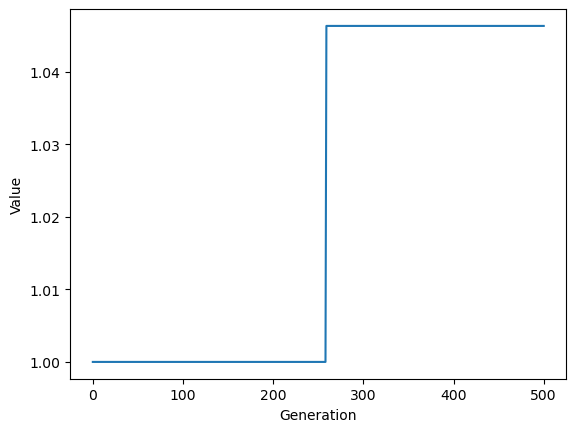

In [22]:
geneticAlgorithmPlot(city=myCity, popSize=pSize, eliteSize=eSize, mutationRate=mRate, generations=ngenerations)

Code by: José Alberto Hoces Castro